# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

In [2]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU
from torch.optim import Adam

from evaluators import DirectEvaluator
from shared_parameters import *
from utils import MLP

torch.set_printoptions(linewidth=120, sci_mode=False)

Let's define our components.

Here our generator NN will define the *offset* from the point in space, that is
also fed in as an input to the generator.

In [193]:
# MLP's input is 2 -> one for the difficulty,
# and one for the embedding space
class Generator(MLP):
    def __init__(self, embedding_size: int, threshold: float, max_iterations: int, hidden=None, activation=None):
        super().__init__(1 + embedding_size, 1, hidden=hidden, activation=activation)

        self.threshold = threshold
        self.max_iterations = max_iterations

        # We then need to initialize the network to output zero offsets initially
        # We'll do that by simply zeroing the weights
        for p in self.parameters():
            p.data.mul_(0.1)

    def forward(self, x, iteration=0):
        # Generate the offset
        offset = super().forward(x)

        seeds = x[:, 1:]
        new_points = seeds + offset
        iterations = torch.ones([x.shape[0], 1], dtype=torch.float32)
        if iteration == self.max_iterations:
            return new_points, iterations

        # Get the points with too big of an offset
        offset_size = torch.norm(offset, dim=-1)
        to_change = offset_size > self.threshold

        # If there are such points, calculate new offsets from the new offset seeds
        if torch.any(to_change):
            d_in = x[:, :1]

            big_offsets = offset[to_change]

            # Adding random perturbations does not seem to help
            # big_offsets = big_offsets + (torch.rand_like(big_offsets) - 0.5) * 0.1

            new_seeds = seeds[to_change] + big_offsets

            new_inputs = torch.hstack((d_in[to_change], new_seeds))

            new_results, new_iterations = self.forward(new_inputs, iteration + 1)

            iterations[to_change] += new_iterations
            new_points[to_change] = new_results

        return new_points, iterations


# We'll define simple remapping function that will map out outputs from

_oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)


def remap(x):
    return x * (enemy_x_max - enemy_x_min) + enemy_x_min


def oracle(x):
    return _oracle(remap(x))


generator = Generator(embedding_size=1, threshold=0.01, max_iterations=5, hidden=[8, 8, 8, 8], activation=LeakyReLU())
optim_generator = Adam(generator.parameters(), lr=0.001)

num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(0, 1, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)


def get_sample(sample_size: int = None):
    if sample_size is None:
        return dataset

    return dataset[torch.randperm(dataset.shape[0])[:sample_size]]


states = generator(get_sample(15))
print()

print(states)

iteration = 0
loss_evaluator = float("inf")


def iterate(verbose=False):
    global dataset, iteration
    sample = get_sample(50)

    states, iterations = generator(sample)
    d_out = oracle(states)

    d_in = sample[:, :1]
    _seeds = sample[:, 1:]

    loss_generator = ((d_in - d_out).abs() / iterations).mean()

    loss = loss_generator

    # seeds_difference = torch.norm(_seeds.unsqueeze(0) - _seeds.unsqueeze(1), dim=-1)
    # states_difference = torch.norm(states.unsqueeze(0) - states.unsqueeze(1), dim=-1)
    #
    # difference = (seeds_difference * states_difference).mean() / 2
    #
    # loss = loss - 0.5 * difference

    # Update the generator
    optim_generator.zero_grad()
    loss.backward()
    optim_generator.step()

    iteration += 1

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"(G) {loss_generator.item():.5f}")

        print("Parameters:")
        for p in generator.parameters():
            print(p.data)

        difficulties = torch.linspace(0, 1, 10)
        seeds = torch.linspace(0, 1, 10)
        dataset = torch.cartesian_prod(difficulties, seeds)

        generated_states = generator(dataset)[0].detach()

        d_out = oracle(generated_states)

        collected = torch.hstack((dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(seeds.shape[0]):
            selected = collected[i::difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            # print(selected)
            # print()
            ax.plot(remap(xs), ds)

        ax.plot(remap(seeds), oracle(seeds))

        ax.legend([*[f"Seed {seed}" for seed in seeds], "Actual"])
        plt.tight_layout()

        plt.show()


iterate()


(tensor([[0.5770],
        [0.9811],
        [0.0316],
        [0.3346],
        [0.3144],
        [0.3952],
        [0.9003],
        [0.7285],
        [0.0013],
        [0.5164],
        [0.7184],
        [0.3346],
        [0.5568],
        [0.1225],
        [0.6881]], grad_fn=<AddBackward0>), tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]))


It.: 396, (G) 0.00492
Parameters:
tensor([[ 0.1461, -0.2345],
        [-0.1179,  0.0696],
        [ 0.2125, -0.3100],
        [ 0.1557, -0.1922],
        [-0.0646,  0.3380],
        [-0.2035,  0.1516],
        [-0.2433,  0.1917],
        [ 0.0130,  0.3467]])
tensor([ 0.0567, -0.0760,  0.0633,  0.0394,  0.0216, -0.0827, -0.0870,  0.0353])
tensor([[-0.2633, -0.0023, -0.2323, -0.2455,  0.2091, -0.2096, -0.1914,  0.2321],
        [ 0.3046, -0.1222,  0.3849,  0.2851, -0.2239,  0.2555,  0.3345, -0.0946],
        [ 0.1490, -0.0099,  0.2397,  0.1928, -0.2639,  0.1245,  0.1488, -0.2505],
        [ 0.2011, -0.1267,  0.2629,  0.2140, -0.2158, -0.1315, -0.0916, -0.0763],
        [-0.3450,  0.0187, -0.3846, -0.2504,  0.3113, -0.3050, -0.3142,  0.2710],
        [ 0.1976, -0.1238,  0.2501,  0.2148, -0.0965,  0.1654,  0.1479, -0.0601],
        [-0.1092, -0.0264, -0.1984, -0.1682,  0.1047, -0.1300, -0.1519,  0.0791],
        [-0.2927,  0.0093, -0.3711, -0.2453,  0.2779, -0.2703, -0.2280,  0.2356]])
ten

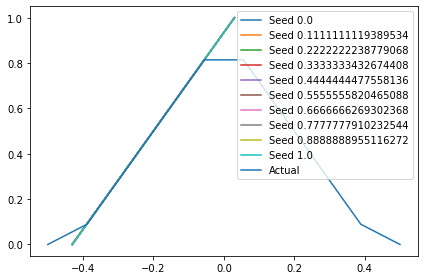

In [194]:
%matplotlib inline
try:
    for _ in range(50):
        for _ in range(10):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)